<p style="text-align: center;"><span style="font-size: 14pt;"><strong>MIR: Automatic Transcription</strong></span></p>
<p style="text-align: center;"><span style="font-size: 11pt;"><strong>Prepared by: Behzad Haki</strong></span></p>
<p style="text-align: center;"><span style="font-size: 14.6667px;">-----------------------------------------------------------------------------------------------</span></p>
<p><span style="font-size: 14.6667px;">In this IPython Notebook, we will go over a simple excersice on Automatic Transcription of monophonic recordings of pitched instruments.&nbsp;</span></p>

In [1]:
import warnings
warnings.filterwarnings('ignore')

#Import Libraries
from IPython.display import Image
from IPython.core.display import HTML 

import essentia.standard as ess  
import mir_eval                       #used for evaluating the detected pitch contours using MIREX dataset
import glob                           #used for searching all the wav files in the MIREX dataset
import numpy as np
from essentia import Pool, array

import freesound, sys,os


#matplotlib
from pylab import plot, show, figure, imshow
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import clear_output

import IPython        #Used for audio playback 

from copy import deepcopy

#Locate Dataset Folder
#MIREXDataFolder = "../data/mirex05TrainFiles"
FreesoundDataFolder = "../data/Freesound"
#ThesisFolder = "../data/Thesis"
AutomaticTranscriptionFolder = "../../data/AutomaticTranscription"

#Create folder if it doesn't exist
if not os.path.isdir(AutomaticTranscriptionFolder):
    os.mkdir(AutomaticTranscriptionFolder)

#Select folder containing the audio files
rootFolder = AutomaticTranscriptionFolder



In [2]:
#Freesound API
client = freesound.FreesoundClient()
your_api_key = "...yourApiKeyGoesHere..."
client_id = "...yourIdGoesHere..."
client.set_token(your_api_key,"token")

#Create Freesound Client Instances
if not os.path.isfile(rootFolder+"/bass.wav"):
    bassFreesound = client.get_sound(31673)
    bassFreesound.retrieve_preview(rootFolder, name="bass.wav")
    
if not os.path.isfile(rootFolder+"/piano.wav"):
    pianoFreesound= client.get_sound(sound_id = 186942, url = "https://freesound.org/people/Lemoncreme/sounds/186942/")
    pianoFreesound.retrieve_preview(rootFolder, name="piano.wav")

if not os.path.isfile(rootFolder+"/flute.wav"):
    fluteFreesound= client.get_sound(sound_id = 65509)
    fluteFreesound.retrieve_preview(rootFolder, name="flute.wav")


In [3]:
#####################################################################################################
#####################################################################################################
#####################################################################################################
##################################   Utility  Functions   ###########################################
#####################################################################################################
#####################################################################################################
#####################################################################################################

def searchFileType (rootFolder = "", types = ["mp3","flac","wav","m4a"], sort = True):
    #This function returns the location of the files with the specified format located in the rootFolder
    # 
    #-----Inputs:
    #            (1) rootFolder:         Folder containing the files with the formats specified in (2)
    #            (2) format:             A list of file formats to search for
    #                                    
    #
    #-----Outputs:
    #            (1) files:             returns a list containing the location of the files found with the specified 
    #                                   formats
    #
    files = []
    count = 0
    for _type in types:
        filesTemp = glob.glob(rootFolder+"/*."+_type)
        if filesTemp!=[]:
            if count>0:
                files.append(glob.glob(rootFolder+"/*."+_type))
            else:
                files=glob.glob(rootFolder+"/*."+_type)
                count+=1
            
    if sort and (files !=[]):
        files = sorted(files)
    
    return files

In [4]:
#Load All Audio Files In the Folder and Append the Location Strings to the audioFiles list
audioFiles = searchFileType(rootFolder=rootFolder, types = ["mp3","flac","wav","m4a"], sort = True)

In [5]:
#####################################################################################################
#####################################################################################################
#####################################################################################################
##################################   Plotting Functions   ###########################################
#####################################################################################################
#####################################################################################################
#####################################################################################################

def plotWave(ax, audioFile, sampleRate = 44100, zoomX = [], zoomY = [], onsets = [], beats = []):
    #ax: matplotlib ax
    audio = ess.MonoLoader(filename = audioFile,sampleRate=sampleRate)()
    time = array(np.arange(len(audio))/float(sampleRate))
    
    ax.plot(time,audio)
    ax.set_title(audioFile+" --> Audio")  
    
    if onsets!=[]:
        ax.vlines(onsets, -1, 1, color='r', linestyle = "--")
        ax.set_title(audioFile+" --> Audio & Detected Onsets")
    if beats!=[]:
        ax.vlines(beats, -1, 1, color='g', linewidth=2.0)
        ax.set_title(audioFile+" --> Audio & Detected Beats")
        
    if zoomX != []:
        ax.set_xlim(zoomX)
    if zoomY != []:
        ax.set_ylim(zoomY)
        

def plotData(ax, timeStamps, data, zoomX = [], zoomY = [], onsets = [], beats = [] , title = "" , color = "b"):
    
    ax.plot(timeStamps, data, color = color)
    ax.set_title(audioFile+" --> "+str(title))  
        
    if zoomX != []:
        ax.set_xlim(zoomX)
    if zoomY != []:
        ax.set_ylim(zoomY)
    
    
def plotVData(ax, timeData, size = 1,zoomX = [], zoomY = [], color = "b", linestyle = ""):
    
    if linestyle!="":
        ax.vlines(timeData, -size, size, color=color, linestyle = linestyle)
    else:
        ax.vlines(timeData, -size, size, color=color)
    
    if zoomX != []:
        ax.set_xlim(zoomX)
    if zoomY != []:
        ax.set_ylim(zoomY)
    

def plotMIDIs(ax, MidiTimesQuantized, QuantizedMIDIgroups, MidiTimesUnquantized,  UnquantizedMIDIGroups, 
             MIDIcolors = ["b", "g"], title="", audioFile = "", onsets = [], beats = [], OnsetBeatcolors = ["r", "o"],
             zoomX = [], zoomY = []):
    
    if title=="":
        ax.set_title(audioFile)    
    else:
        if audioFile!="":
            ax.set_title(audioFile+" --> "+str(title)) 
        else:
            ax.set_title(str(title)) 
    
    groupCount = 0
    for QuantizedMIDIgroup in QuantizedMIDIgroups:
        ax.plot(MidiTimesUnquantized[groupCount],UnquantizedMIDIGroups[groupCount], color=MIDIcolors[1])
        
        ax.plot(MidiTimesQuantized[groupCount],QuantizedMIDIgroup, color=MIDIcolors[0], marker ="o")
        groupCount+=1
        
    if beats!=[]:
        plotVData(ax, beats, size = 150, color=OnsetBeatcolors[1])
    if onsets!=[]:
        plotVData(ax, onsets, size = 150, color=OnsetBeatcolors[0],linestyle="--")

        
    if zoomX != []:
        ax.set_xlim(zoomX)
    if zoomY != []:
        ax.set_ylim(zoomY)


def plotMIDI(ax, MidiTimes, QuantizedMIDIgroups, MIDIcolors = "b", 
             title="", audioFile="" ,onsets = [], beats = [], OnsetBeatcolors = ["r","g"],
             zoomX = [], zoomY = []):
    
    if title=="":
        ax.set_title(audioFile)    
    else:
        if audioFile!="":
            ax.set_title(audioFile+" --> "+str(title)) 
        else:
            ax.set_title(str(title)) 
        
    
    groupCount = 0
    for QuantizedMIDIgroup in QuantizedMIDIgroups:
        #print (MidiTimeQuantized[groupCount])
        #print (QuantizedMIDIgroup)        
        ax.plot(MidiTimes[groupCount],QuantizedMIDIgroup, color=MIDIcolors, marker ="o")
        groupCount+=1

    if onsets!=[]:
        plotVData(ax, onsets, size = 150, color=OnsetBeatcolors[0],linestyle="--")        
    if beats!=[]:
        plotVData(ax, beats, size = 150, color=OnsetBeatcolors[1])


        
    if zoomX != []:
        ax.set_xlim(zoomX)
    if zoomY != []:
        ax.set_ylim(zoomY)

def plotBarMIDI(ax, MidiTimes, QuantizedMIDIgroups, MIDIcolors = "b", 
                title="", audioFile = "",onsets = [], beats = [], OnsetBeatcolors = ["r","g"],
                zoomX = [], zoomY = []):    

    if title=="":
        ax.set_title(audioFile)    
    else:
        if audioFile!="":
            ax.set_title(audioFile+" --> "+str(title)) 
        else:
            ax.set_title(str(title)) 
        
    if onsets!=[]:
        plotVData(ax, onsets, size = 150, color=OnsetBeatcolors[0],linestyle="--")       
        
    if beats!=[]:
        plotVData(ax, beats, size = 150, color=OnsetBeatcolors[1])     
    
    groupCount = 0
    
    for QuantizedMIDIgroup in QuantizedMIDIgroups:
        width = MidiTimes[groupCount][1]-MidiTimes[groupCount][0]
        midiVal = (QuantizedMIDIgroup[0])
        ax.barh(bottom=midiVal, width=width, left=MidiTimes[groupCount][0], height=1)
        groupCount+=1

    if zoomX != []:
        ax.set_xlim(zoomX)
    if zoomY != []:
        ax.set_ylim(zoomY)



In [6]:
#####################################################################################################
#####################################################################################################
#####################################################################################################
##################################   Analysis Functions   ###########################################
#####################################################################################################
#####################################################################################################
#####################################################################################################

def getPredominantPitch(audio, sampleRate,frameSize,hopSize, minFrequency=50,maxFrequency=2000):
    
    
    pitchMelodia = ess.PitchMelodia(guessUnvoiced=True,
                                            frameSize=frameSize,
                                            hopSize=hopSize,
                                            maxFrequency=maxFrequency,
                                            minFrequency=minFrequency,
                                            sampleRate=sampleRate)
    estPitch, pitchConfidence = pitchMelodia(audio)
    return np.array(estPitch), pitchConfidence
    
def pitch2midi (pitchArray, quantizePitch = True):
    midi = []
    for pitch in pitchArray:
        if pitch==0:
            midi.append(0)
        else:
            if quantizePitch:
                midi.append(np.int(np.round(69+12*np.math.log(pitch/440.0,2),0)))
            else:
                midi.append(69+12*np.math.log(pitch/440.0,2))
    return midi

def getOnsets (audio, sampleRate = 44100, frameSize = 1024,hopSize = 256, winType = "hann",method = "complex"):
    W = ess.Windowing(type=winType)
    c2p = ess.CartesianToPolar()
    fft = ess.FFT()
    onsetDetection = ess.OnsetDetection(method = method, sampleRate = sampleRate)
    onsets = ess.Onsets()  
    onsetIndex = []
    pool = Pool()
    
    for frame in ess.FrameGenerator(audio, frameSize = frameSize, hopSize = hopSize):
        mag, phase, = c2p(fft(W(frame)))
        onsetDetection.configure(method=method)
        onsetFunction = onsetDetection(mag,phase)
        pool.add("onsetFunction",onsetFunction)
            
    DetectedOnsetsArray = onsets([pool["onsetFunction"]],[1])
    
    return DetectedOnsetsArray

def consecutive(data, stepsize=0):
    #source: https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-from-an-array-in-numpy
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def splitUnquantizedMIDI(midiArrayQuantized,midiArrayUnquantized, minFrame = 1, sampleRate = 44100, hopSize = 256):
    #minFrame specifies the minimum frame duration of a midi note to be accepted as a segment
    
    MIDIgroups = consecutive(midiArrayQuantized, stepsize=0)
    TimeStamps = [] #timeStamps in s
    
    groupCount = 0
    indexCount = 0
    MIDIgroupsProcessed = []
    indexStamps = []
    
    for groupCount in range(len(MIDIgroups)):
        MIDIgroup = MIDIgroups[groupCount]
        if min(MIDIgroup)>0.0 and len(MIDIgroup)>=minFrame:
            indexStamp = np.arange(indexCount,indexCount+len(MIDIgroup))
            TimeStamps.append(np.arange(indexCount,indexCount+len(MIDIgroup))*hopSize/float(sampleRate)) 
            indexStamps.append(indexStamp)
            
            MIDIgroupsProcessed.append(midiArrayUnquantized[indexStamp])
            
        indexCount=indexCount+len(MIDIgroup)

    #print (TimeStamps)   
    
    return indexStamps, TimeStamps, MIDIgroupsProcessed

def splitQuantizedMIDI(midiArrayQuantized, minFrame = 1, sampleRate = 44100, hopSize = 256):
    #minFrame specifies the minimum frame duration of a midi note to be accepted as a segment
    MIDIgroups = consecutive(midiArrayQuantized, stepsize=0)
    TimeStamps = [] #timeStamps in s
    
    groupCount = 0
    indexCount = 0
    MIDIgroupsProcessed = []
    indexStamps = []
    for groupCount in range(len(MIDIgroups)):
        MIDIgroup = MIDIgroups[groupCount]
        if min(MIDIgroup)>0.0 and len(MIDIgroup)>=minFrame:
            MIDIgroupsProcessed.append([MIDIgroup[0],MIDIgroup[0]])
            times = np.arange(indexCount,indexCount+len(MIDIgroup))*hopSize/float(sampleRate) 
            indices = np.arange(indexCount,indexCount+len(MIDIgroup))
            
            TimeStamps.append([times[0], times[-1]])
            indexStamps.append([indices[0], indices[-1]])
        indexCount=indexCount+len(MIDIgroup)

    return indexStamps, TimeStamps, MIDIgroupsProcessed
            
def getBeats (audioFile, sampleRate = 44100):
    audio = ess.MonoLoader(filename = audioFile,sampleRate=sampleRate)()    
    BeatTracker = ess.BeatTrackerMultiFeature()
    beats,_ = BeatTracker(audio)
    return beats

def find_nearest(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    return array[idx]

def splitAtOnsets (timeStamps, MIDIGroups, onsets): #Only for pitch quantized groups ---> Not Used
    timeStampGroups = deepcopy(timeStamps)
    newTimeStamps = []
    newMIDIGroups = []
    
    for i in range(len(timeStampGroups)):
        timeStampGroup = timeStampGroups[i]
        if(timeStampGroup[0]!=timeStampGroup[1]):
            onsetsInGroup = list(onset for onset in onsets if timeStampGroup[0]<onset<timeStampGroup[1])
            
            timeStampGroup.extend(onsetsInGroup)
            timeStampGroup = sorted(timeStampGroup)
            timeStampGroup = np.unique(timeStampGroup)
        
        for k in range(len(timeStampGroup)-1):
                        
            newTimeStamps.append([timeStampGroup[k],timeStampGroup[k+1]])
            newMIDIGroups.append(MIDIGroups[i])
    
    return newTimeStamps, newMIDIGroups

def createGrid(beats, beatDivision):
    #beatDivision needs to be int > 1
    #endTime is end of the file or can also be where griding stops
    if beatDivision<1:
        beatDivision = 1
    else:
        beatDivision = int(beatDivision)
    
    if len(beats)==1:
        print ("can't create grid with only a beat marker")
        return []
    
    
    gridRes = (beats[1]-beats[0])/float(beatDivision) #resolution of grid in ms
    
    grid = [0]
    
    if beatDivision ==1:
        grid = beats
    else:
        for k in range(1,beatDivision+1): #create the possibly missing grids before beat 0
            if beats[0]-k*gridRes>0:
                grid.append(beats[0]-k*gridRes)
                
        for i in range(len(beats)):
            if not i == len(beats)-1:
                gridRes = (beats[i+1]-beats[i])/float(beatDivision) #resolution of grid in ms
            for k in range(beatDivision):
                grid.append(beats[i]+k*gridRes)
        

    return grid
                

def RemoveTracksAwayFromOnsets (MIDItimeStamps, MIDIGroups, onsets, minLength = .1, postOnsetPecentage = .5,hopSize = 256, SampleRate=44100):
    #Removes MIDI tracks that start too far away from the existing onsets
    #far away defined as more than minLength (seconds)
    #also if the majority of a track is before the nearest onset, the track is discarded
    
    MIDITracks = []
    MIDITrackTimes = []
    #print (len(MIDItimeStamps), len(MIDIGroups))
    for i in range(len(MIDItimeStamps)):
        MIDItimeStamp = MIDItimeStamps[i]
        MIDIGroup = MIDIGroups[i]
        #print (MIDItimeStamp[0])
        nearestOnset = find_nearest(onsets,MIDItimeStamp[0])
        checkDistance = abs(nearestOnset-MIDItimeStamp[0])<(minLength)
        
        if (abs(MIDItimeStamp[1]-nearestOnset)-abs(nearestOnset-MIDItimeStamp[0])>.8*(MIDItimeStamp[1]-MIDItimeStamp[0])):
            checkMajorityPostOnset = True
        else:
            checkMajorityPostOnset = False
            
        if checkDistance and checkMajorityPostOnset:
            MIDITracks.append(MIDIGroup)
            MIDITrackTimes.append(MIDItimeStamp)
        #else:
        #    print(i,print (find_nearest(onsets,MIDItimeStamp[0])-MIDItimeStamp[0]))
    return MIDITrackTimes, MIDITracks

def RemoveShortTracks (MIDItimeStamps, MIDIGroups, onsets, minLength= 4, hopSize = 256, SampleRate=44100):
    #minLength in terms of frames
    MIDITracks = []
    MIDITrackTimes = []
    for i in range(len(MIDItimeStamps)):
        MIDItimeStamp = MIDItimeStamps[i]
        MIDIGroup = MIDIGroups[i]  
        if (MIDItimeStamp[1]-MIDItimeStamp[0])*SampleRate > minLength*hopSize:
            MIDITracks.append(MIDIGroup)
            MIDITrackTimes.append(MIDItimeStamp)
    return MIDITrackTimes, MIDITracks

def SnapToGrid(MIDItimeStamps, MIDIGroups, grid, snapBeginning = True, snapEnd = True):
    MIDItimeStampsCopy = deepcopy(MIDItimeStamps)
    
    for i in range(len(MIDItimeStamps)):
        if snapBeginning:
            MIDItimeStampsCopy[i][0] = find_nearest(grid,MIDItimeStampsCopy[i][0])
        if snapEnd:
            MIDItimeStampsCopy[i][1] = find_nearest(grid,MIDItimeStampsCopy[i][1])
        
    return MIDItimeStampsCopy, MIDIGroups

def existingMIDIValues(MIDIGroups):
    #returns just the midi values extracted (sorted with no duplicates)
    existingMIDIs = np.array([])
    
    for MIDIGroup in MIDIGroups:
        existingMIDIs=np.append(existingMIDIs, MIDIGroup[0])
    
    existingMIDIs = np.unique(existingMIDIs).tolist()
    
    return sorted(existingMIDIs)


In [7]:
#####################################################################################################
#####################################################################################################
#####################################################################################################
#########################################   Analyzer   ##############################################
#########################################      &       ##############################################
#########################################   Plotter    ###########################################
#####################################################################################################
#####################################################################################################
#####################################################################################################

def extractorEssentia (audioFile, onset_method = "hfc", winType = "hann", 
                       sampleRate = 44100, onsetframeSize = 4096, onsethopSize = 256, 
                       pitchframeSize = 4096,pitchhopSize = 256, 
                       minFrequency=30, maxFrequency=2000 , beatDivision = 4,
                       deleteWhereNoOnset = True, onsetToStartMaxSecs = .1, postOnsetPecentage = .5, 
                       splitWhereOnset = True, deleteShortTracks = True, 
                       minFramesofTrack=1, snapGrid = True):
    
    frameSize = onsetframeSize
    hopSize = onsethopSize
    #create the results pool
    analysisResults = dict()
    
    #load file
    audio = ess.MonoLoader(filename = audioFile,sampleRate=sampleRate)()
    time = array(np.arange(len(audio))/float(sampleRate))
    #pool.add("audio",audio)
    #pool.add("time",time)
    
    #Find the Predominant Pitch in every frames
    estPitch, _ = getPredominantPitch(audio, sampleRate = sampleRate,frameSize=pitchframeSize,hopSize=pitchhopSize,
                                      minFrequency=minFrequency,maxFrequency=maxFrequency)
    #convert pitch to MIDI
    estMIDI = pitch2midi (estPitch,quantizePitch = True)
    estTime = array(np.arange(len(estMIDI))*pitchhopSize/float(sampleRate))
    analysisResults["estTime"] = estTime
    #Find the onset locations
    onsets = getOnsets(audio, sampleRate = sampleRate, frameSize = onsetframeSize,hopSize = onsethopSize, 
                       winType = winType, method = onset_method)
    analysisResults["onsets"] = onsets
    
    #Convert quantized/unquantized midis to essentia arrays
    estUnquantizedMIDI = array(pitch2midi(estPitch, quantizePitch = False))
    estQuantizedMIDI = array(pitch2midi(estPitch, quantizePitch = True))
    analysisResults["estUnquantizedMIDI"]=estUnquantizedMIDI  
    analysisResults["estQuantizedMIDI"] = estQuantizedMIDI    

    #Calculate beats using onsets and define the Grid 
    beats = getBeats (audioFile)
    grid = createGrid(beats, beatDivision)
    analysisResults["beats"]=beats
    analysisResults["grid"]=grid
    
    #Split the quantized/unquantized MIDI arrays into seperate groups
    _, MidiTimesQuantized, QuantizedMIDIgroups = splitQuantizedMIDI(estQuantizedMIDI, minFrame = 0, 
                                                                    sampleRate = sampleRate, hopSize = pitchhopSize)

    _, MidiTimesUnquantized, UnquantizedMIDIgroups = splitUnquantizedMIDI(estQuantizedMIDI, estUnquantizedMIDI, 
                                                                          minFrame = 0, sampleRate = sampleRate, hopSize = pitchhopSize)
    
    analysisResults["PitchQuantized.TimeStamps.Original"]=MidiTimesQuantized
    analysisResults["PitchQuantized.MIDIgroups.Original"]=QuantizedMIDIgroups
    analysisResults["Unquantized.MidiTimes.Original"]=MidiTimesUnquantized        #just for plotting
    analysisResults["Unquantized.MIDIgroups.Original"]=UnquantizedMIDIgroups      #just for plotting
    
    #Remove if no onset in the vicinity of the start of the track
    if deleteWhereNoOnset:
        MIDITrackTimes, MIDITracks = RemoveTracksAwayFromOnsets (MidiTimesQuantized, QuantizedMIDIgroups, onsets, 
                                                                 minLength = onsetToStartMaxSecs, 
                                                                 postOnsetPecentage = postOnsetPecentage ,
                                                                 SampleRate=sampleRate)
    else:
        MIDITrackTimes, MIDITracks = MidiTimesQuantized, QuantizedMIDIgroups
    
    analysisResults["PitchQuantized.TimeStamps.CloseToOnsets"] = MIDITrackTimes
    analysisResults["PitchQuantized.MIDIGroups.CloseToOnsets"] = MIDITracks 
    
    #Split where onset appears within a track
    if splitWhereOnset:
        onsetSplittedTimeStampsQuantized, onsetSplittedQuantizedMIDIGroups = splitAtOnsets (MIDITrackTimes, 
                                                                                            MIDITracks, 
                                                                                            onsets)    
    else:
        onsetSplittedTimeStampsQuantized, onsetSplittedQuantizedMIDIGroups = MIDITrackTimes, MIDITracks

    analysisResults["PitchQuantized.TimeStamps.onsetSplitted"] = onsetSplittedTimeStampsQuantized
    analysisResults["PitchQuantized.MIDIGroups.onsetSplitted"] = onsetSplittedQuantizedMIDIGroups
    
    #delete short tracks
    if (deleteShortTracks):
        MIDITrackTimesSplitted, MIDITracksSplitted = RemoveShortTracks (onsetSplittedTimeStampsQuantized, 
                                                                        onsetSplittedQuantizedMIDIGroups, 
                                                                        onsets, minLength= minFramesofTrack, 
                                                                        hopSize = pitchhopSize, SampleRate=sampleRate)
    
    else:
        MIDITrackTimesSplitted, MIDITracksSplitted = onsetSplittedTimeStampsQuantized, onsetSplittedQuantizedMIDIGroups
   
    analysisResults["PitchQuantized.TimeStamps.removedShortTracks"]= MIDITrackTimesSplitted
    analysisResults["PitchQuantized.MIDIGroups.removedShortTracks"]= MIDITracksSplitted

    #Time Quantize the Tracks (snap beginning and end to grid)
    if snapGrid:
        MIDITrackTimesSnapped, MIDITracksSnapped = SnapToGrid(MIDITrackTimesSplitted, MIDITracksSplitted, 
                                                              grid, snapBeginning = True, snapEnd = True)
    else:
        MIDITrackTimesSnapped, MIDITracksSnapped = MIDITrackTimesSplitted, MIDITracksSplitted
    
    analysisResults["Time&PitchQuantized.TimeStamps"]=MIDITrackTimesSnapped
    analysisResults["Time&PitchQuantized.MIDIGroups"]=MIDITracksSnapped
    
    
    return analysisResults

def plotAll (analysisResults, audioFile, zoomX = [], zoomY = [],allPlots = True , sampleRate = 44100):

    #Load Data to Plot
    audio = ess.MonoLoader(filename = audioFile,sampleRate=sampleRate)()

    #load extractor data
    estTime = analysisResults["estTime"]
    onsets = analysisResults["onsets"]
    estUnquantizedMIDI = analysisResults["estUnquantizedMIDI"]
    estQuantizedMIDI =  analysisResults["estQuantizedMIDI"]
    beats = analysisResults["beats"]
    grid = analysisResults["grid"]
    MidiTimesQuantized = analysisResults["PitchQuantized.TimeStamps.Original"]
    QuantizedMIDIgroups = analysisResults["PitchQuantized.MIDIgroups.Original"]
    MidiTimesUnquantized = analysisResults["Unquantized.MidiTimes.Original"]
    UnquantizedMIDIgroups = analysisResults["Unquantized.MIDIgroups.Original"]
    MIDITrackTimes = analysisResults["PitchQuantized.TimeStamps.CloseToOnsets"]
    MIDITracks = analysisResults["PitchQuantized.MIDIGroups.CloseToOnsets"]
    onsetSplittedTimeStampsQuantized = analysisResults["PitchQuantized.TimeStamps.onsetSplitted"]
    onsetSplittedQuantizedMIDIGroups = analysisResults["PitchQuantized.MIDIGroups.onsetSplitted"]
    
    MIDITrackTimesSplitted = analysisResults["PitchQuantized.TimeStamps.removedShortTracks"]
    MIDITracksSplitted = analysisResults["PitchQuantized.MIDIGroups.removedShortTracks"]
    
    MIDITrackTimesSnapped = analysisResults["Time&PitchQuantized.TimeStamps"]
    MIDITracksSnapped = analysisResults["Time&PitchQuantized.MIDIGroups"]
    
    if zoomX == []:
        zoomX = [0, estTime[-1]+.2]
        
    if zoomY == []:
        midiVals = existingMIDIValues(QuantizedMIDIgroups)
        zoomY = [min(midiVals)-3, max(midiVals)+3]
        print (zoomY)
    
    
        
    #Plots
    if allPlots:
        f, axarr1 = plt.subplots(7,1,figsize=(25, 50))    

        #Plot Wave with Onsets
        plotWave(axarr1[0], audioFile, sampleRate = 44100, zoomX = zoomX, onsets = onsets, beats = [])        
        plotWave(axarr1[1], audioFile, sampleRate = 44100, zoomX = zoomX, onsets = [], beats = beats) 

        #Plot Quantized Pitch VS Unquantized Pitch (in MIDI Number)
        
        plotMIDIs(axarr1[2], MidiTimesQuantized, QuantizedMIDIgroups, MidiTimesUnquantized, UnquantizedMIDIgroups, \
                  MIDIcolors = ["b","m"], onsets = onsets, beats = [],OnsetBeatcolors = ["r", "g"],zoomX = zoomX, \
                  zoomY = zoomY, title = "Quantized Pitch VS. Unquantized Pitch - All MIDI Tracks")

        #Plot MIDIs cleaned up (midis away from onsets are removed)
        plotMIDI(axarr1[3], MIDITrackTimes, MIDITracks, zoomX = zoomX, zoomY = zoomY, \
                 title="Quantized Pitch VS. Unquantized Pitch - Removed MIDI Tracks Far from Onsets", \
                 onsets = onsets, beats = [], OnsetBeatcolors = ["r","g"])

        #Plot MIDIs Splitted 
        plotMIDI(axarr1[4], MIDITrackTimesSplitted, MIDITracksSplitted, 
                 zoomX = zoomX, zoomY = zoomY, 
                 title="Quantized Pitch VS. Unquantized Pitch - Removed MIDI Tracks Splitted at Onsets & Short Tracks Removed",
                 onsets = onsets, beats = [], OnsetBeatcolors = ["r","g"])

        #Plot MIDIs Splitted with onsets
        plotMIDI(axarr1[5], MIDITrackTimesSplitted, MIDITracksSplitted, zoomX = zoomX, zoomY = zoomY, \
                 title="Quantized Pitch VS. Unquantized Pitch - Removed MIDI Tracks Splitted at Onsets & Short Tracks Removed",
                 onsets = grid, beats = beats, OnsetBeatcolors = ["r","g"])

        #Plot MIDIs Snapped with grid
        if zoomY == []:
            midiVals = existingMIDIValues(MIDITracksSnapped)
            zoomY = [min(midiVals)-3, max(midiVals)+3]
            print (zoomY)
            
        plotBarMIDI(axarr1[6], MIDITrackTimesSnapped, MIDITracksSnapped, zoomX = zoomX, zoomY = zoomY, \
                    title="Time Quantized Extracted MIDI Tracks",
                    onsets = grid, beats = beats, OnsetBeatcolors = ["r","g"])
        axarr1[6].tick_params(axis = "y", direction='out', length=6, width=1, colors='k')
        axarr1[6].grid(color='k', axis= 'y', linestyle='--', linewidth=.25, which='both')
 
    else:
        f, axarr1 = plt.subplots(2,1,figsize=(25, 12.5))    

        #Plot Wave with Onsets
        plotWave(axarr1[0], audioFile, sampleRate = 44100, zoomX = zoomX, onsets = onsets, beats = beats) 
        
        #plot Final MIDI Plot
        #Plot MIDIs Snapped with grid
        if zoomY == []:
            midiVals = existingMIDIValues(MIDITracksSnapped)
            zoomY = [min(midiVals)-3, max(midiVals)+3]
            print (zoomY)
            
        plotBarMIDI(axarr1[1], MIDITrackTimesSnapped, MIDITracksSnapped, zoomX = zoomX, zoomY = zoomY, \
                    title="Time Quantized Extracted MIDI Tracks",
                    onsets = grid, beats = beats, OnsetBeatcolors = ["r","g"])
        

In [12]:
Image(url= "http://i65.tinypic.com/14nhg1u.jpg")



[49.0, 84.0]


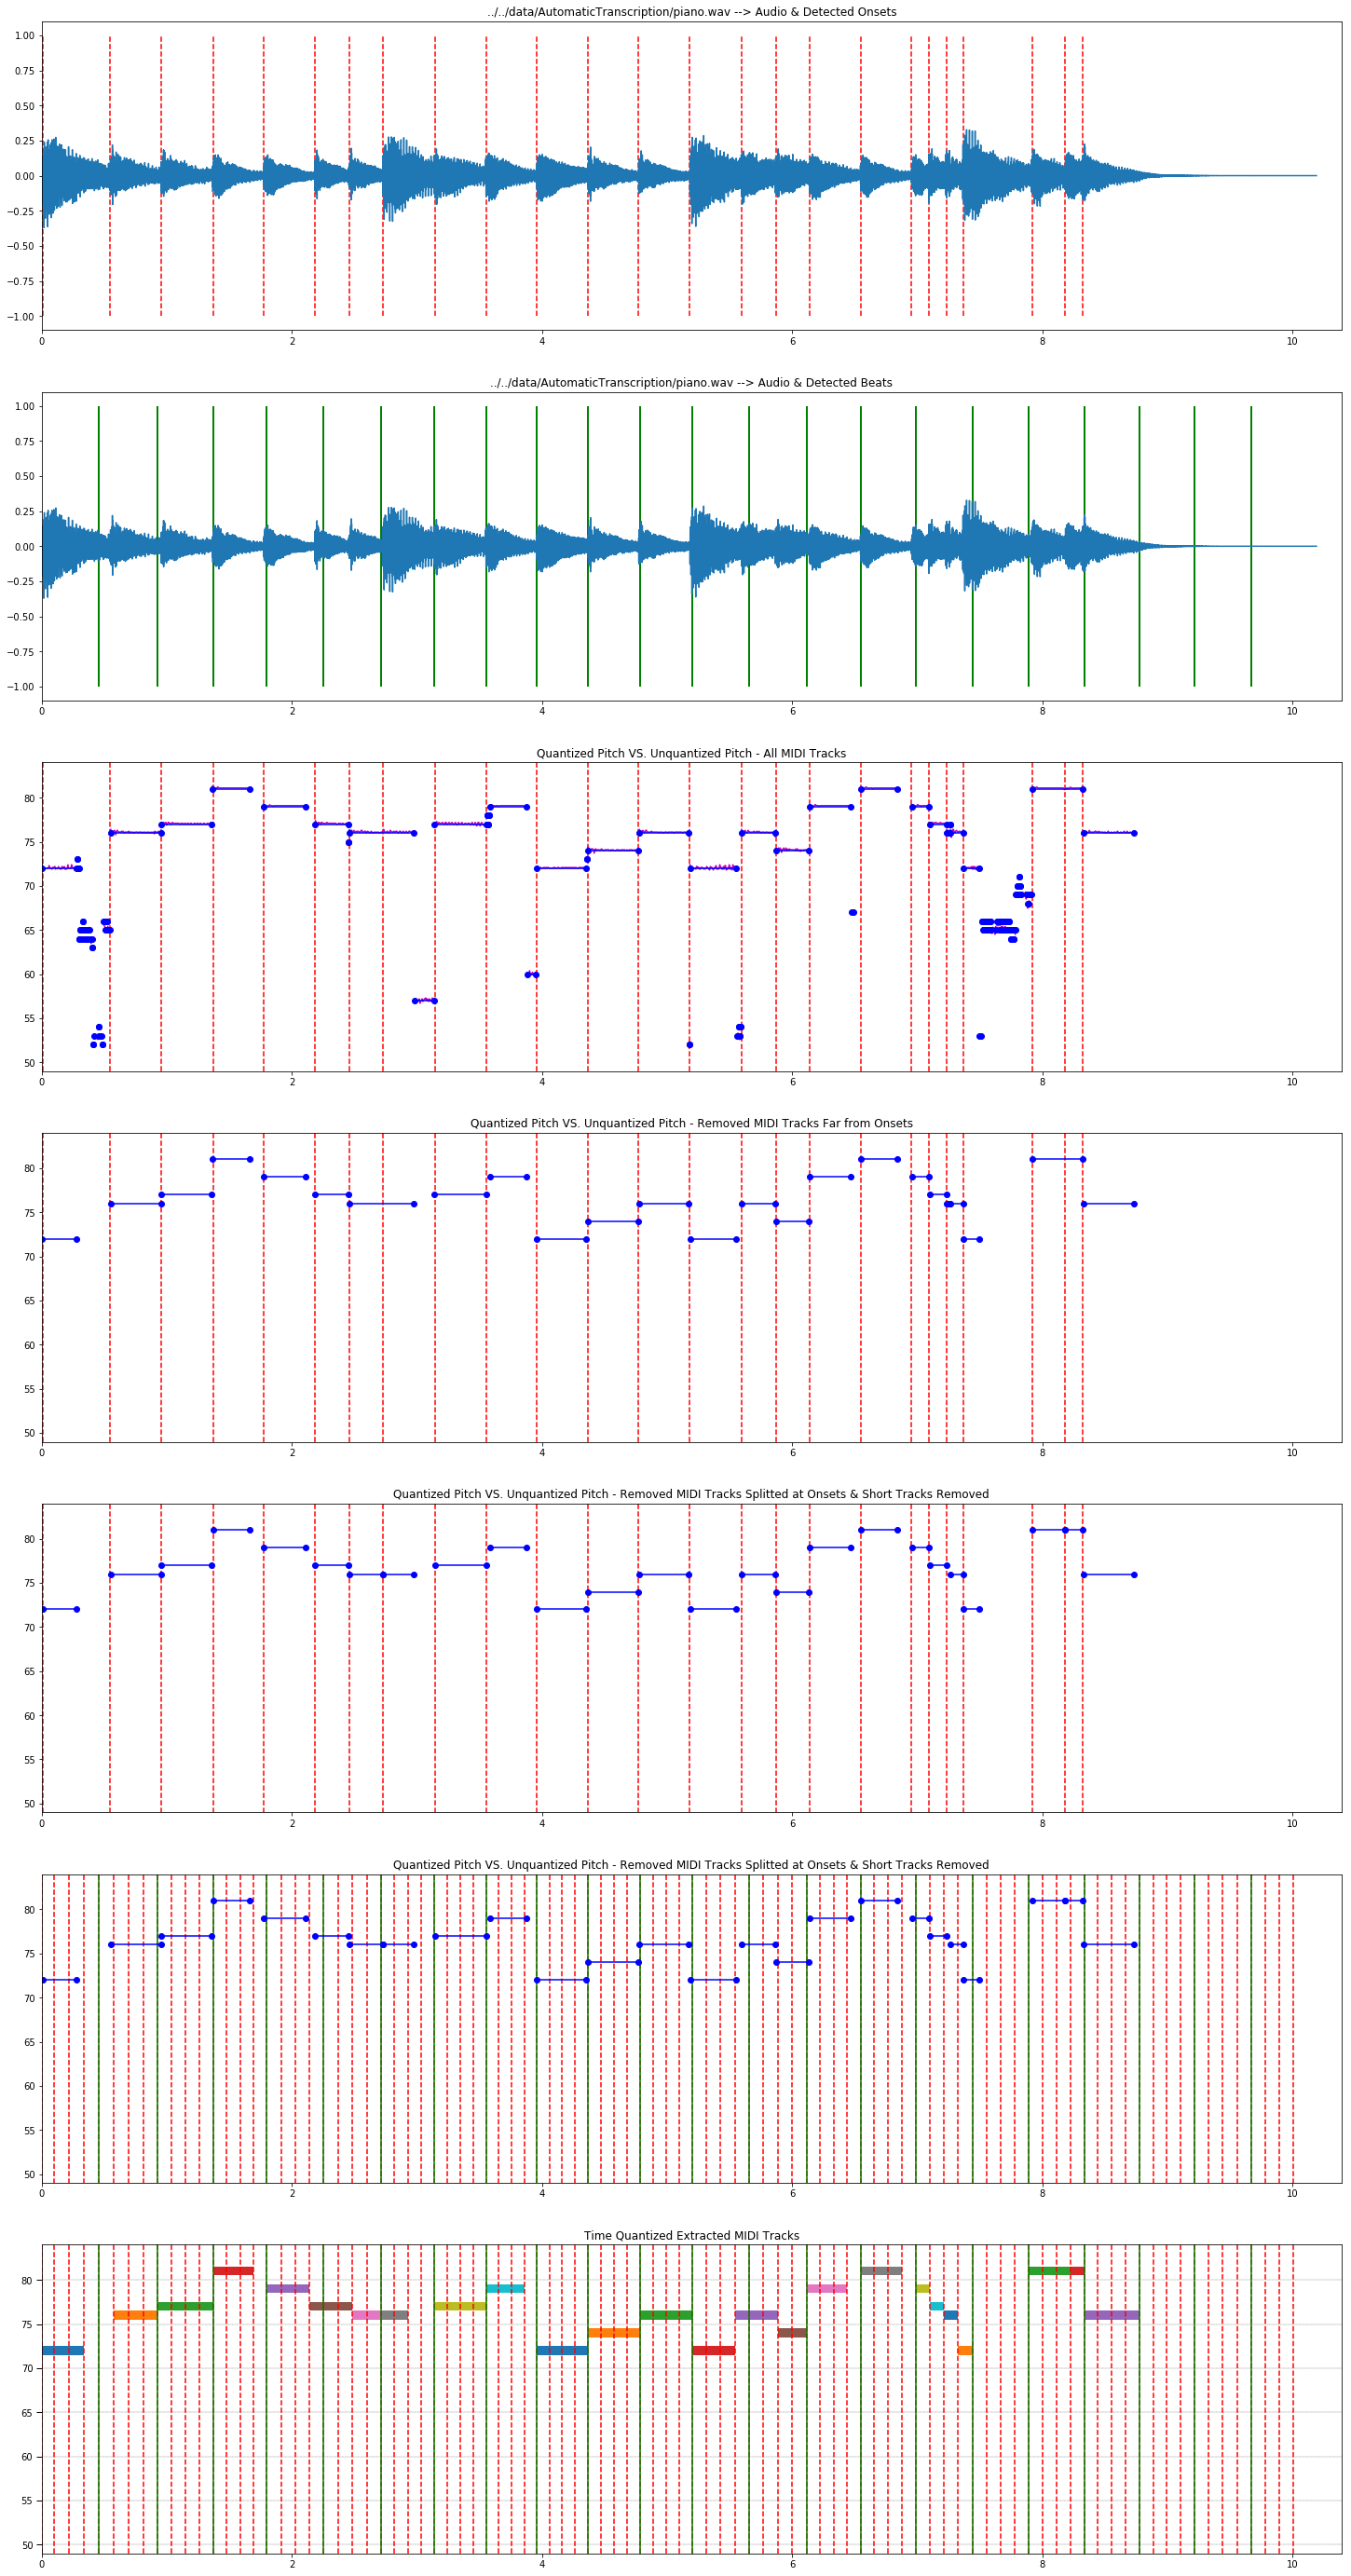

In [14]:
#Piano
indexToPlot = 2
sampleRate = 44100



#Run Analysis
analysisResults=extractorEssentia(audioFiles[indexToPlot], onset_method = "hfc", winType = "hann", 
                                  sampleRate = 44100, onsetframeSize = 1024, onsethopSize = 512,
                                  pitchframeSize = 1024, pitchhopSize = 256,
                                  minFrequency=30, maxFrequency=2000 , beatDivision = 4,
                                  deleteWhereNoOnset = True, onsetToStartMaxSecs = .1, postOnsetPecentage = .5,
                                  splitWhereOnset = True, deleteShortTracks = True, 
                                  minFramesofTrack=4, snapGrid = True)

#Plotting Parameters
zoomX = []; zoomY = []
#zoomX = []; zoomY = [70,83]

plotAll (analysisResults, audioFiles[indexToPlot],zoomX = zoomX, zoomY = zoomY,allPlots = True , sampleRate = sampleRate)

audio = ess.MonoLoader(filename = audioFiles[indexToPlot],sampleRate=sampleRate)()  

if zoomX == []:
    dataToPlay = audio
else:
    dataToPlay = audio[zoomX[0]*sampleRate:zoomX[1]*sampleRate]
IPython.display.Audio(dataToPlay,rate=sampleRate)

[30.0, 50.0]


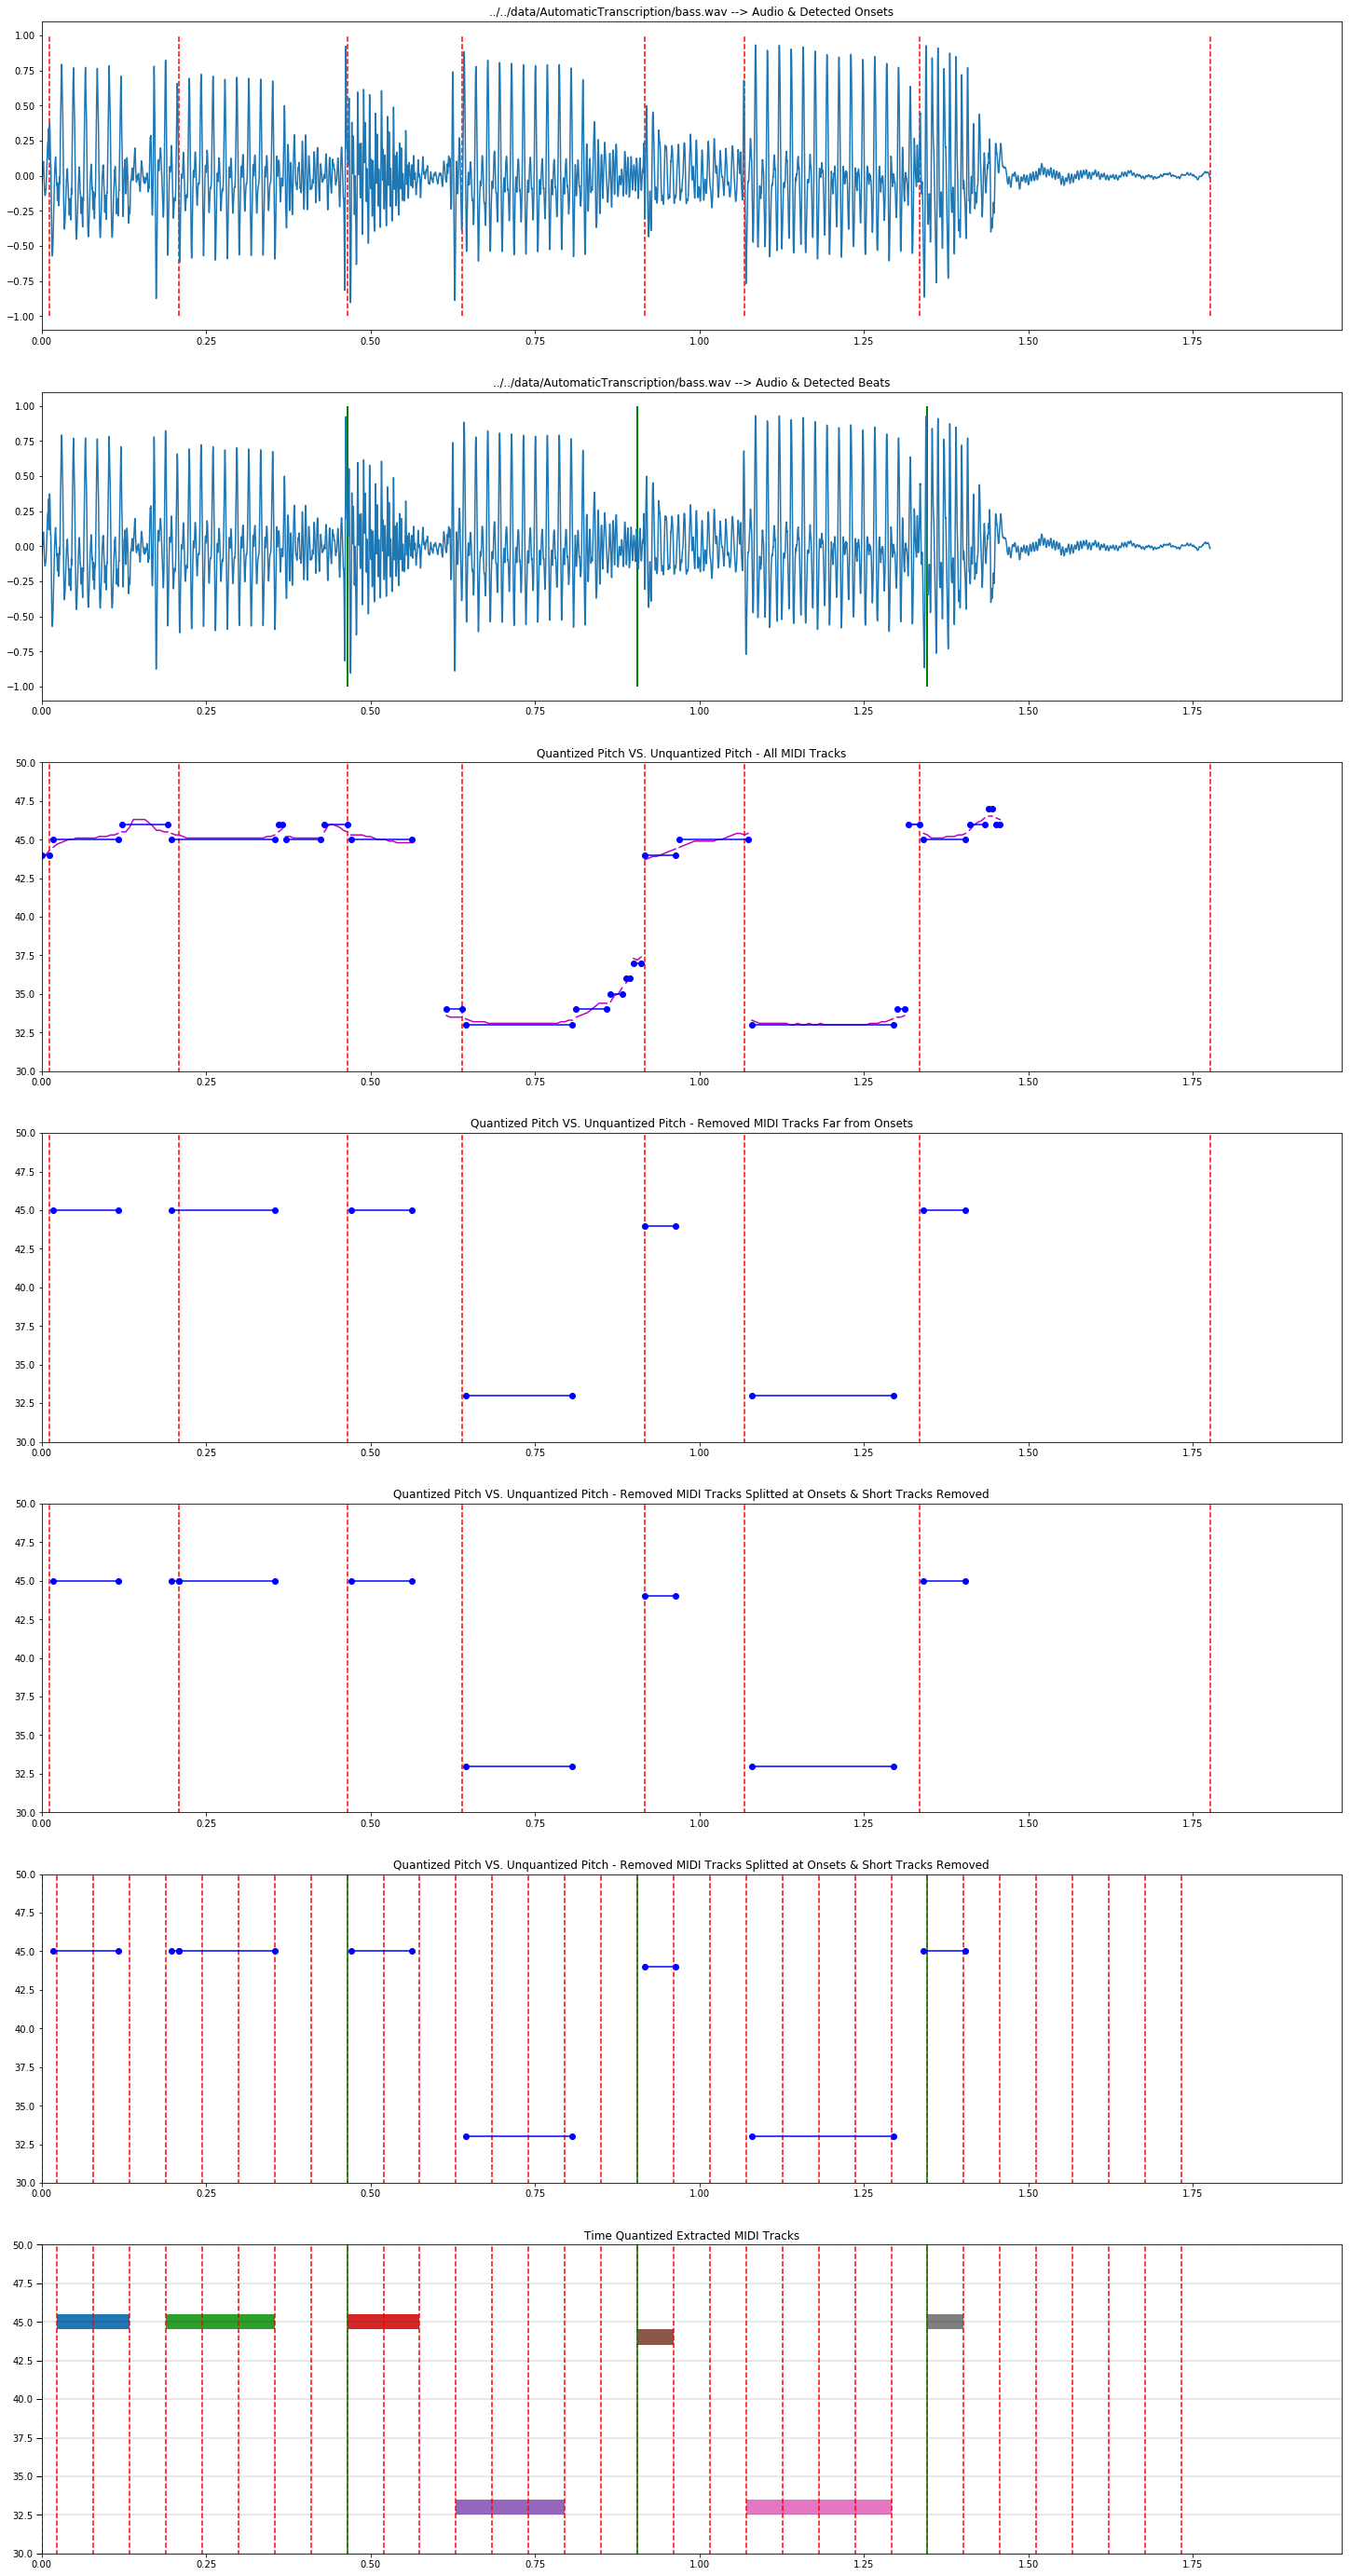

In [16]:
#BASS
indexToPlot = 0
sampleRate = 44100

#Run Analysis
analysisResults=extractorEssentia(audioFiles[indexToPlot], onset_method = "hfc", winType = "hann", 
                                  sampleRate = 44100, onsetframeSize = 1024, onsethopSize = 512,
                                  pitchframeSize = 4096, pitchhopSize = 256,
                                  minFrequency=30, maxFrequency=2000 , beatDivision = 8,
                                  deleteWhereNoOnset = True, onsetToStartMaxSecs = .05, postOnsetPecentage = .5,
                                  splitWhereOnset = True, deleteShortTracks = True, 
                                  minFramesofTrack=1, snapGrid = True)

#Plotting Parameters
zoomX = []; zoomY = []
#zoomX = [0,2]; zoomY = [30,35]

plotAll (analysisResults, audioFiles[indexToPlot], zoomX = zoomX, zoomY = zoomY,allPlots = True, sampleRate = sampleRate)

audio = ess.MonoLoader(filename = audioFiles[indexToPlot],sampleRate=sampleRate)()  

if zoomX == []:
    dataToPlay = audio
else:
    dataToPlay = audio[zoomX[0]*sampleRate:zoomX[1]*sampleRate]
IPython.display.Audio(dataToPlay,rate=sampleRate)

[56.0, 75.0]


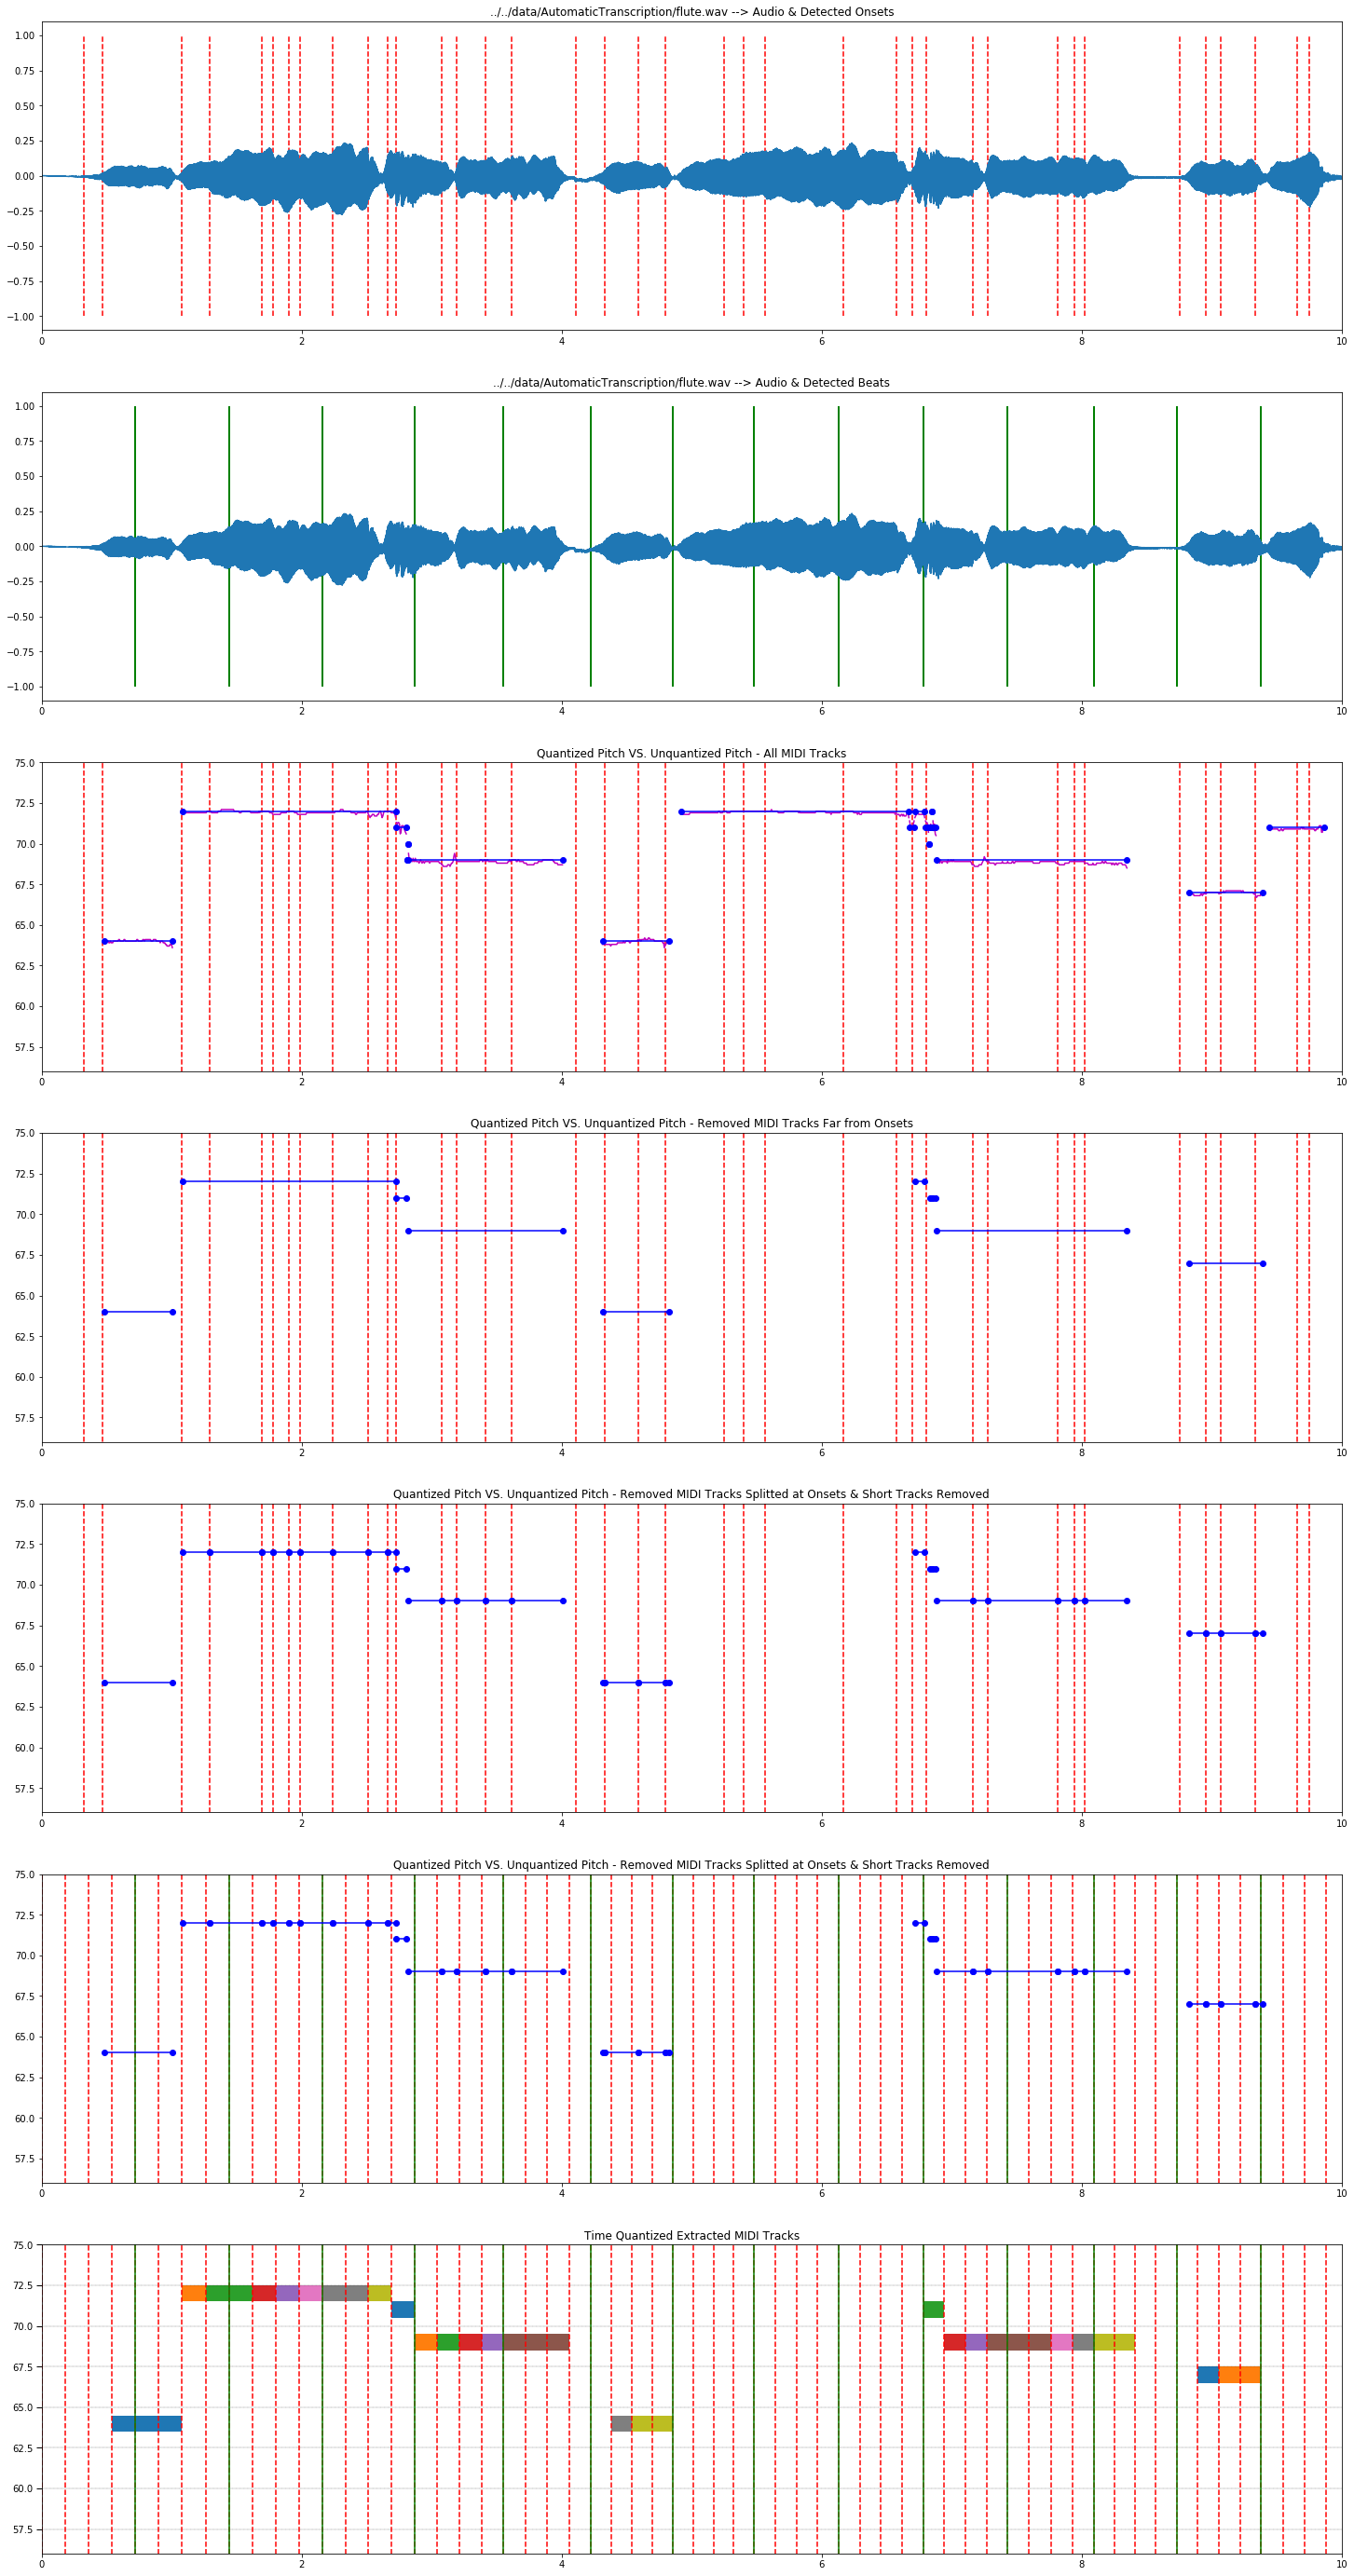

In [11]:
#Flute
indexToPlot = 1
sampleRate = 44100

#Run Analysis
analysisResults=extractorEssentia(audioFiles[indexToPlot], onset_method = "complex", winType = "hann", 
                                  sampleRate = 44100, onsetframeSize = 1024, onsethopSize = 512,
                                  pitchframeSize = 1024, pitchhopSize = 256,
                                  minFrequency=30, maxFrequency=2000 , beatDivision = 4,
                                  deleteWhereNoOnset = True, onsetToStartMaxSecs = .1, postOnsetPecentage = .5,
                                  splitWhereOnset = True, deleteShortTracks = True, 
                                  minFramesofTrack=1, snapGrid = True)

#Plotting Parameters
zoomX = []; zoomY = []
zoomX = [0,10]; zoomY = []

plotAll (analysisResults, audioFiles[indexToPlot], zoomX = zoomX, zoomY = zoomY,allPlots = True, sampleRate = sampleRate)

audio = ess.MonoLoader(filename = audioFiles[indexToPlot],sampleRate=sampleRate)()  

if zoomX == []:
    dataToPlay = audio
else:
    dataToPlay = audio[zoomX[0]*sampleRate:zoomX[1]*sampleRate]
IPython.display.Audio(dataToPlay,rate=sampleRate)